In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib
import matplotlib.pyplot as plt
from scipy import misc
from skimage import color
import skimage.io as skio
import cv2
from scipy.ndimage.interpolation import rotate

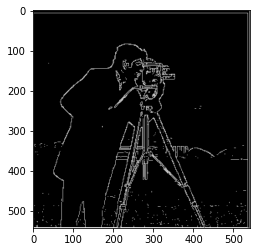

In [2]:
%matplotlib inline
#1.1
dx = [[1, -1], [0, 0]]
dy = [[1, 0], [-1, 0]]

def img_derivative(image, thrsh):
    dxi = signal.convolve2d(image, dx)
    dyi = signal.convolve2d(image, dy)
    
    xmask = abs(dxi[:,:]) > thrsh
    ymask = abs(dyi[:,:]) > thrsh
    
    final = xmask + ymask
    return final

cameraman = (skio.imread('cameraman.png')[:,:,0])
plt.imshow(img_derivative(cameraman, 50), cmap="gray")

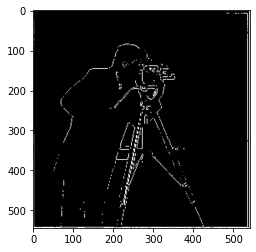

In [3]:
#1.2
def blur_derivative(image, thrsh):
    g = cv2.getGaussianKernel(2, 1)
    g = np.outer(g, np.transpose(g))
    blur = signal.convolve2d(image, g)
    return img_derivative(blur, thrsh)

plt.imshow(blur_derivative(cameraman, 50), cmap="gray")

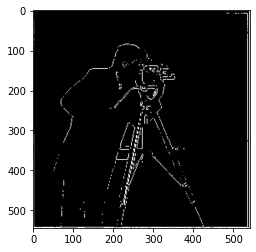

In [4]:
#1.2
def dog_derivative(image, thrsh):
    g = cv2.getGaussianKernel(2, 1)
    g = np.outer(g, np.transpose(g))
    dxg = signal.convolve2d(g, dx)
    dyg = signal.convolve2d(g, dy)
    dxi = signal.convolve2d(image, dxg)
    dyi = signal.convolve2d(image, dyg)
    
    xmask = abs(dxi[:,:]) > thrsh
    ymask = abs(dyi[:,:]) > thrsh
    
    final = xmask + ymask
    return final
plt.imshow(dog_derivative(cameraman, 50), cmap="gray")

In [5]:
#1.3
facade = (skio.imread('facade.jpg'))
def get_center(image):
    percent = 0.8
    edges = (1 - percent) / 2
    x1 = int(round(image.shape[0] * edges))
    x2 = int(round(image.shape[0] - (image.shape[0] * edges)))
    y1 = int(round(image.shape[1] * edges))
    y2 = int(round(image.shape[1] - (image.shape[0] * edges)))
    return image[x1:x2, y1:y2]

def auto_rotate(image):
    biggest = 0
    biggest_angle = 0
    def perp_ratio(grad):
        perp = abs(abs(grad[:,:]) - 90) < 5
        count = sum(sum(perp))
        nonperp = abs(abs(grad[:,:]) - 90) > 5
        total =  count + sum(sum(nonperp))
        ratio = count / total
        return ratio
    
    for theta in range(-40, 40, 2):
        rotated = rotate(image, theta)
        center = get_center(rotated)
        dxi = signal.convolve2d(center, dx)
        dyi = signal.convolve2d(center, dy)
        
        x_ratio = perp_ratio(dxi)
        y_ratio = perp_ratio(dyi)
        if (x_ratio + y_ratio) > biggest:
            biggest = x_ratio + y_ratio
            biggest_angle = theta
    return biggest_angle
plt.imshow(rotate(facade, auto_rotate(facade[:,:,0])))

KeyboardInterrupt: 

In [ ]:
#2.1
taj = (skio.imread('taj.jpg'))
def sharpen(image):
    g = cv2.getGaussianKernel(15, 1)
    g = np.outer(g, np.transpose(g))
    shape = image.shape
    RGB_shape = (shape[0], shape[1], 1)
    blur1 = signal.convolve2d(image[:,:,0], g, mode='same')
    blur2 = signal.convolve2d(image[:,:,1], g, mode='same')
    blur3 = signal.convolve2d(image[:,:,2], g, mode='same')
    
    return np.clip(image + ((image - np.dstack([blur1, blur2, blur3]))*10), 0, 255)
plt.imshow(sharpen(taj), cmap='gray')
    

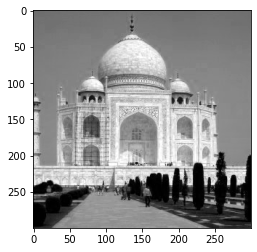

In [37]:
plt.imshow(taj[:,:,0], cmap='gray')

In [7]:
#2.2
#ALIGN STARTER
import math
import skimage.transform as sktr
%matplotlib qt
def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale)
    else:
        im2 = sktr.rescale(im2, 1./dscale)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2



ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt5' interactive framework, as 'headless' is currently running

Please select 2 points in each image for alignment.


ValueError: not enough values to unpack (expected 2, got 0)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/tushar/anaconda3/envs/194/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/tushar/anaconda3/envs/194/lib/python3.6/site-packages/matplotlib/backends/backend_webagg.py", line 44, in run
    tornado.ioloop.IOLoop.instance().start()
  File "/home/tushar/anaconda3/envs/194/lib/python3.6/site-packages/tornado/ioloop.py", line 201, in instance
    return IOLoop.current()
  File "/home/tushar/anaconda3/envs/194/lib/python3.6/site-packages/tornado/ioloop.py", line 265, in current
    loop = asyncio.get_event_loop()
  File "/home/tushar/anaconda3/envs/194/lib/python3.6/asyncio/events.py", line 694, in get_event_loop
    return get_event_loop_policy().get_event_loop()
  File "/home/tushar/anaconda3/envs/194/lib/python3.6/asyncio/events.py", line 602, in get_event_loop
    % threading.current_thread().name)
RuntimeError: There is no current event loop in thread 'Thread-4'.



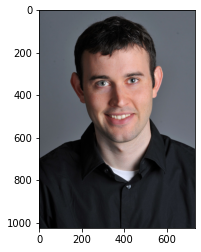

In [10]:
#HYBRID STARTER
# First load images

# high sf
im1 = plt.imread('hybrid_python/DerekPicture.jpg')/255

# low sf
im2 = plt.imread('hybrid_python/nutmeg.jpg')/255

# Next align images (this code is provided, but may be improved)
im1_aligned, im2_aligned = align_images(im1, im2)

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies